# Pratical Session : Stochastic Bandits

Code adapted from https://github.com/yfletberliac/rlss-2019 (Practical Sessions of RLSS 2019: Bandits, RL & Deep RL. https://rlss.inria.fr/program/)

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.insert(0,'Utils')

In [5]:
import numpy as np
from matplotlib import pyplot as plt
import time
from scipy.optimize import linprog


# Bandit specific functions and classes 
import Utils.Arms as arm
from Utils.StochasticBandit import *
from Utils.StochasticBandit import MAB_NON_S
from Utils.BanditTools import * 
import Utils.BanditBaselines as alg

### Lets test the non stationary bandit class

In [161]:
nbArms = 3
ts = [3,7,10]
bandit = MAB_NON_S(k = nbArms, TS=ts, seed=42)

print("The means of bandit instance are", bandit.means)

The means of bandit instance are [0.37454012 0.95071431 0.73199394]


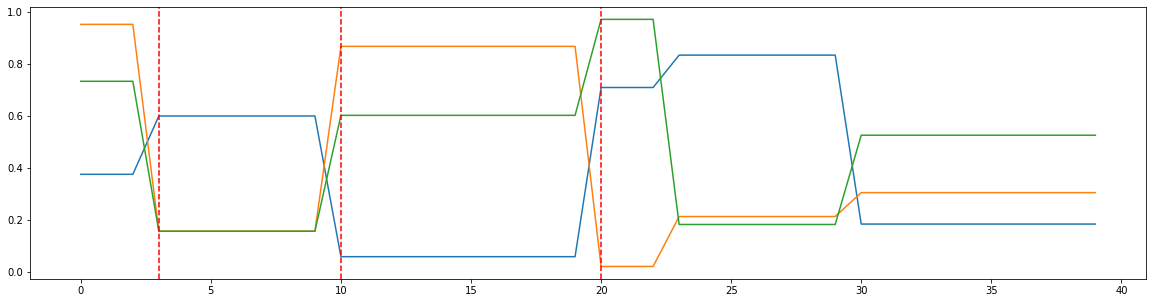

In [163]:
bandit.restore()
means = []
for _ in range(sum(ts)*2):
    means.append(bandit.means)
    bandit.generateReward(0)
plt.figure(figsize=(20,5))
plt.plot(means)

# vertical bars for TS
for i in range(len(ts)):
    plt.axvline(x=sum(ts[:i+1]), color='r', linestyle='--')
plt.show()

scheduler uses TS to schedule when distribution should be changed

#### Executing strategy

The function given below executes one bandit algorithm on one MAB instance. 

In [167]:
def OneBanditOneLearnerOneRun(bandit, learner, timeHorizon):
    """
    Run a bandit strategy (learner) on a MAB instance (bandit) for (timeHorizon) time steps
    output : sequence of arms chosen, sequence of rewards obtained
    """
    bandit.restore()
    selections = []
    rewards = []
    learner.clear() # reset previous history
    for t in range(timeHorizon):
        arm = learner.chooseArmToPlay()
        reward = bandit.generateReward(arm)
        learner.receiveReward(arm, reward)
        # Update statistics
        selections.append(arm)
        rewards.append(reward)
    return selections, rewards, bandit

For UCB : $ \delta_t=t^{-2}(t+1)^{-1}$

In [197]:
timeHorizon = 3000
# nbArms = 7
# bandit = GaussianBandit([-1, 0, 1, 2, 3, 3, 2]) # directly creates a Gaussian bandit from a vector of means
# bandit = GaussianBandit([-1, 0, 1]) # directly creates a Gaussian bandit from a vector of means
nbArms = 3
bandit = MAB_NON_S(k = nbArms, seed=41)

UCBlearner = alg.UCB(nbArms, delta = lambda t : t **(-2) * ( t+1 )**(-1))
selections, rewards, UCBbandit = OneBanditOneLearnerOneRun(bandit, UCBlearner, timeHorizon) # I gived the same bandits, but they are restored at the beggining
UCBregret = UCBbandit.cumulativeRegret()

FTLlearner = alg.FTL(nbArms)
selections, rewards, FTLbandit = OneBanditOneLearnerOneRun(bandit, FTLlearner, timeHorizon) # I gived the same bandits, but they are restored at the beggining
FTLregret = FTLbandit.cumulativeRegret()

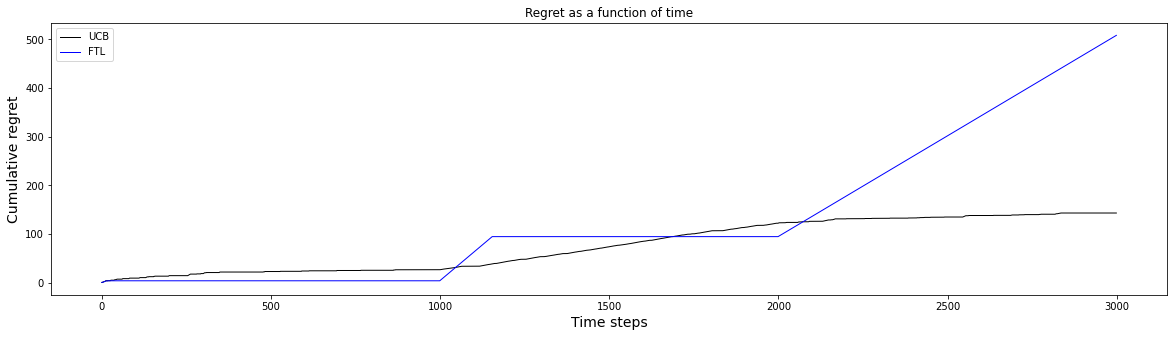

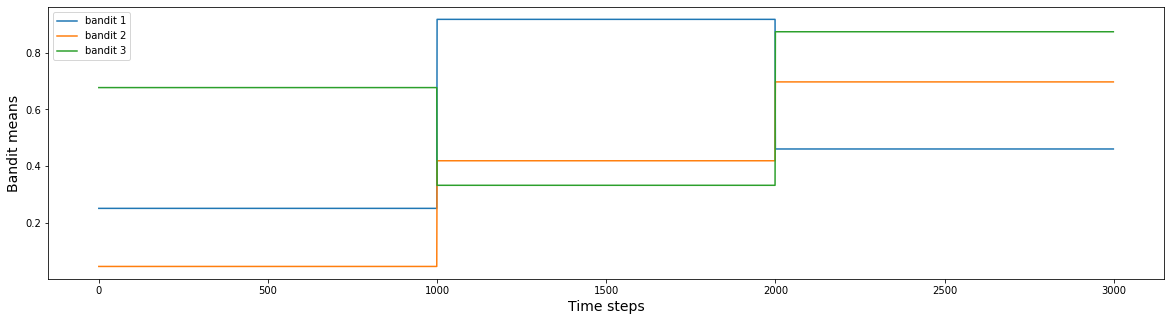

In [198]:
# Visualize results (on one run) 

# Histogram of the number of arms selections
# plt.figure(figsize=(20,5))
# plt.clf()
# plt.xlabel("Arms", fontsize=14)
# plt.ylabel("Number of arms selections", fontsize=14)
# plt.hist(selections, max(selections) + 1)
# plt.title("Number of selections of each arm", fontsize=14)
# plt.savefig('./Figure/test'+ learner.name() + '.pdf')

# Cumulative regret as a function of time
plt.figure(2, figsize=(20,5))
plt.clf()
plt.xlabel("Time steps", fontsize=14)
plt.ylabel("Cumulative regret", fontsize=14)
plt.title("Regret as a function of time")
plt.plot(range(timeHorizon), UCBregret, 'black', linewidth=1, label=UCBlearner.name())
plt.plot(range(timeHorizon), FTLregret, 'b', linewidth=1, label=FTLlearner.name())
plt.legend()
plt.show()

plt.figure(figsize=(20,5))
plt.plot(bandit.historical_means)
plt.legend(['bandit ' + str(i+1) for i in range(nbArms)])
plt.xlabel("Time steps", fontsize=14)
plt.ylabel("Bandit means", fontsize=14)
plt.show()